# The Final Trajectory

In order to compute the dynamics in SEOBNRv5HM, we will need to implement the corresponding equations of motion and a numerical integration routine.

The equations of motion require as inputs:
- The masses $m_{1,2}$ in normalized masses, i.e $m_1 + m_2 = 1$.
- The spins $\chi_1$, and $\chi_2$ of the binary in dimensionless units.
- The values of the primitive variables $(r,\phi,p_{r_*},p_{\phi})$.
It then computes:
- The partial derivatives of the Hamiltonian w.r.t the positions, $\tfrac{\partial H}{\partial r}$ and momenta $\tfrac{\partial H}{\partial p_{(r_*,\phi)}}$.
- The tortoise parameter $\xi$.
- The Hamiltonian $H$, the circular frequency $\Omega_{\rm circ}$ that are then used to solve for the flux $F_{\phi}$
And returns the time derivative of each of the primitive variables given by Hamilton's equations of motion as well as the prescription for the radiation-reaction.

The numerical integration routine is split into two parts
- An initial sparsely sampled integration that stops at given stopping conditions
- A finely sampled integration from some stepback time to the stopping conditions to calculate the Non-Quasi-Circular (NQC) Coefficients

In this notebook, we will generate three files:
- The set of expressions needed to generate the equations of motions
- The numerical routines needed to generate the trajectory

Finally, the numerical integration requires as inputs:
- The initial conditions, documented in the initial conditions routine
- The stopping conditions, documented in this notebook
- All other inputs needed for the equations of motion 

In [1]:
import sys,os#Add sys to get cmdline_helper from NRPy top directory; remove this line and next when debugged
sys.path.append('../')
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface

# Create C code output directory:
Ccodesdir = "Dynamics"
# Then create an output directory in case it does not exist
cmd.mkdir(Ccodesdir)

# Step : The Equations of Motions

The equations of motion are given by:

\begin{equation*}
\dot{r} = \frac{1}{\nu}\xi \frac{\partial H}{\partial p_{r_{*}}}\\
\dot{\phi} = \Omega\\
\dot{p}_{r_*} = \frac{1}{\nu}\left(-\xi \frac{\partial H}{\partial r} + \frac{ p_{ r_{*} }F_{\phi} }{ p_{\phi} }\right)\\
\dot{p}_{\phi} = \frac{1}{\nu}F_{\phi}
\end{equation*}

Where, $\nu$ is the symmetric mass ratio, $F_{\phi}$ is the gravitational wave flux, $\frac{\partial H}{\partial \zeta}$ is the partial derivative of the Hamiltonian, $H$, with respect to the primitive variable $\zeta = \{r,\phi,p_{r_{*}},p_\phi\}$.  

In [2]:
%%writefile $Ccodesdir/v5HM_Equations_Of_Motion.txt
rdot = (xi/eta)*dHdprstar(m1,m2,r,prstar,pphi,chi1,chi2)
phidot = Omega
prstardot = (1/eta)*(-xi*dHdr(m1,m2,r,prstar,pphi,chi1,chi2) + prstar*F_phi/pphi)
pphidot = F_phi/eta

Overwriting Dynamics/v5HM_Equations_Of_Motion.txt


# Step : $F_{\phi}$

The gravitational wave flux is given as a function of the primitive variables $\{r,\phi,p_{r_{*}},p_{\phi}\}$, the masses $\{m_1,m_2\}$, the spins $\{\chi_{1},\chi_{2}\}$, the rotational frequency $\Omega$, the circular frequency $\Omega_{\rm circ}$, and the Hamiltonian $H$.

$$
F_{\phi} \equiv F_{\phi}(m_1,m_2,r,p_{r_{*}},p_{\phi},\chi_1,\chi_2,\Omega,\Omega_{\rm circ},H)
$$

In [3]:
%%writefile -a $Ccodesdir/v5HM_Equations_Of_Motion.txt
F_phi = flux(m1, m2, r, phi, prstar, pphi, chi1, chi2,Omega,Omega_circ,H)/Omega

Appending to Dynamics/v5HM_Equations_Of_Motion.txt


# Step : $\Omega$

The rotational frequency is given by:

$$
\Omega = \frac{1}{\nu}\frac{\partial H}{\partial p_{\phi}}
$$

In [4]:
%%writefile -a $Ccodesdir/v5HM_Equations_Of_Motion.txt
Omega = (1/eta)*dHdpphi(m1,m2,r,prstar,pphi,chi1,chi2)

Appending to Dynamics/v5HM_Equations_Of_Motion.txt


# Step : $\Omega_{\rm circ}$

The circular frequency is given by:

$$
\Omega = \frac{1}{\nu}\left.\frac{\partial H}{\partial p_{\phi}}\right|_{p_{r_{*}} = 0}
$$

In [5]:
%%writefile -a $Ccodesdir/v5HM_Equations_Of_Motion.txt
Omega_circ = (1/eta)*dHdpphi_preq0(m1,m2,r,pphi,chi1,chi2)

Appending to Dynamics/v5HM_Equations_Of_Motion.txt


# Step : $H$, $\xi$

The Hamiltonian and the tortoise parameter are given as the result of the Hamiltonian computation, which in turn is a function of the primitive variables and the input parameters

In [6]:
%%writefile -a $Ccodesdir/v5HM_Equations_Of_Motion.txt
H , xi = Hamiltonian(m1,m2,r,prstar,pphi,chi1,chi2)

Appending to Dynamics/v5HM_Equations_Of_Motion.txt


# Step : $\eta$

The symmetric mass ratio is defined as follows

$$
\eta = \frac{m_{1}m_{2}}{(m_1 + m_2)^2}
$$

In [7]:
%%writefile -a $Ccodesdir/v5HM_Equations_Of_Motion.txt
eta = m1*m2/(m1 + m2)/(m1 + m2)

Appending to Dynamics/v5HM_Equations_Of_Motion.txt


# Step : Write into python function

In [8]:
with open(os.path.join(Ccodesdir,"v5HM_Equations_Of_Motion.py"), "w") as output:
    output.write("import numpy as np\n")
    output.write("from Radiation.v5HM_Flux_unoptimized import v5HM_unoptimized_flux as flux\n")
    output.write("from Derivatives.v5HM_Hamiltonian_Derivatives_unoptimized import v5HM_unoptimized_omega_circ as dHdpphi_preq0\n")
    output.write("from Derivatives.v5HM_Hamiltonian_Derivatives_unoptimized import v5HM_unoptimized_dH_dpphi as dHdpphi\n")
    output.write("from Derivatives.v5HM_Hamiltonian_Derivatives_unoptimized import v5HM_unoptimized_dH_dprstar as dHdprstar\n")
    output.write("from Derivatives.v5HM_Hamiltonian_Derivatives_unoptimized import v5HM_unoptimized_dH_dr as dHdr\n")
    output.write("from Hamiltonian.v5HM_Hamiltonian_unoptimized import v5HM_unoptimized_hamiltonian as Hamiltonian\n")
    output.write("def v5HM_unoptimized_rhs(t,y,m1,m2,chi1,chi2,verbose = False):\n    r , phi , prstar , pphi = y[0] , y[1] , y[2] , y[3]\n")
    for line in reversed(list(open(os.path.join(Ccodesdir,"v5HM_Equations_Of_Motion.txt"),"r"))):
        output.write("    %s\n" % line.rstrip())
    output.write("    if not verbose:\n        return np.array([rdot,phidot,prstardot,pphidot])\n")
    output.write("    else:\n        return np.array([rdot,phidot,prstardot,pphidot]), F_phi, Omega, Omega_circ, xi, dHdr(m1,m2,r,prstar,pphi,chi1,chi2)/eta, eta, prstar,pphi\n")

import numpy as np
from Dynamics.v5HM_Equations_Of_Motion import v5HM_unoptimized_rhs as rhs_bob
from Dynamics.pyseobnr_equations_of_motion import get_rhs as rhs_true

eta = 0.1
m1 = 0.5*(1 + np.sqrt(1 - 4*eta))
m2 = 0.5*(1 - np.sqrt(1 - 4*eta))
chi1 = 0.5
chi2 = 0.9
r = 10.
phi = 0.
prstar = 20.
pphi = 22.

dyn_bob = rhs_bob(0.,[r,phi,prstar,pphi],m1,m2,chi1,chi2,verbose = True)
dyn_true = rhs_true(0.,[r,phi,prstar,pphi],chi1,chi2,m1,m2, verbose = True)

print(dyn_bob)
print(dyn_true)

(array([ 3.30125969e+01,  3.61796457e-04,  1.20434146e+01, -2.27212811e-07]), -2.2721281123014508e-08, 0.0003617964574513582, 0.08604882064625258, 0.8057888518672409, -14.946117393523147, 0.09999999999999999, 20.0, 22.0)
([33.01259690985122, 0.00036179645745135826, 12.043414567842925, -2.272128112301455e-07], -2.272128112301455e-07, 0.00036179645745135826, 0.08604882064625256, 0.8057888518672411, -14.946117393523155, 0.09999999999999999, 20.0, 22.0)


# Step : The Stopping Conditions

The stopping conditions are given in lines 152-178 of [integrate_ode.py](https://git.ligo.org/waveforms/software/pyseobnr/-/blob/main/pyseobnr/eob/dynamics/integrate_ode.py) of pyseobnr.

There are several termination conditions that are checked when $r < 6$:

- Peak orbital frequency : If the value of $\Omega$ has decreased since the last timestep.
- Positive radial velocity: If $\dot{r} > 0$
- Positive radial momentum derivative: If $\dot{p_{r_{*}}} > 0$
- Radius reaches threshold: If the radius reaches some threshold radius (conditionally defined by numerical relativity and the Kerr metric last stable circular orbit)
- Unphysical circular frequency at low $r$'s: if $r < 3M$ and $\Omega_{\rm circ} > 1$

We will define each of these conditions below.

# Step : The First Integration

In the first integration, the initial conditions are evaluated and the trajectory is evolved until the above specified stopping conditions are accomplished. 
pyseobnr uses `pygsl_lite` to access gsl's `odeiv2` tools. We use the equivalent `scipy.odeint` tools.

We use an adaptive Runge-Kutta 45 method with relative tolerance `1e-11` and absolute tolerance `1e-12`

In [10]:
import time
from Dynamics.v5HM_Initial_Conditions import v5HM_initial_conditions as IC
from scipy.integrate import solve_ivp
event = lambda t,y,m1,m2,chi1,chi2 : y[0] - 6.0
event.terminal = True

M = 33.
q = 23./10.
S1 = 0.5
S2 = 0.9
f = 20
m1 = q/(1 + q)
m2 = 1/(1+q)
event = lambda t,y,a,b,c,d : y[0] - 6.
event.terminal = True
yinit = IC(M,q,S1,S2,f)
sol_bob = solve_ivp(rhs_bob,[0.,20000.],yinit,method = 'RK45',events = [event], args = (m1,m2,S1,S2), rtol = 1e-11, atol = 1e-12)
sol_true = solve_ivp(rhs_true,[0.,20000.],yinit,method = 'RK45',events = [event], args = (S1,S2,m1,m2), rtol = 1e-11, atol = 1e-12)

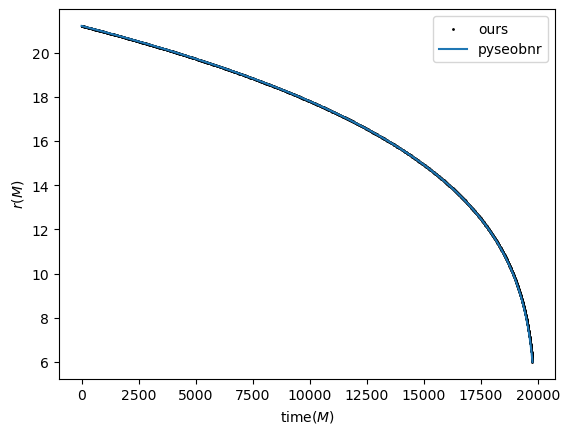

In [11]:
import matplotlib.pyplot as plt
import numpy as np
t_bob = sol_bob.t
t_true = sol_true.t
r_bob = sol_bob.y[0]
r_true = sol_true.y[0]
plt.scatter(t_bob,r_bob,s = 1,label = 'ours',color = 'black')
plt.plot(t_true,r_true,label = 'pyseobnr')
plt.xlabel(r'time($M$)')
plt.ylabel(r'$r$($M$)')
plt.legend()
plt.savefig('first_trajectory_eta_1_chi1_5_chi2_9.png',dpi = 300)

# Step : The Second Integration